<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5230_07_Arnab/blob/main/Facial_Vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
zip_path = "/content/archive.zip"
extract_path= "/content"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print(f"Files Extracted to:{extract_path}")

Files Extracted to:/content


In [2]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Input,Dense, Dropout
from keras.layers import Flatten,Conv2D,MaxPooling2D,BatchNormalization



In [3]:
train_dir = "/content/train"
test_dir = "/content/test"

In [4]:
image_size=(48,48)
batch_size=64       #key hyperparameter, it refers to the no of training examples used in 1 iteration of updating the models weight
epochs=50

In [5]:
def count_images(dir):
  total_images= 0

  for sub_dir,_,files in os.walk(dir):
    total_images += len(files)

  return total_images

train_images= count_images(train_dir)
test_images= count_images(test_dir)

print(f"Total Training Images:{train_images}")
print(f"Total Testing Images:{test_images}")

Total Training Images:28709
Total Testing Images:7178


In [6]:
def count_images_per_dir(dir):

  for sub_dir,_,files in os.walk(dir):
    total_images = len(files)
    print(f"{sub_dir} contents:{total_images}")

print("Training set images count in each folder")
count_images_per_dir(train_dir)

print("Testing set images count in each folder")
count_images_per_dir(test_dir)


Training set images count in each folder
/content/train contents:0
/content/train/sad contents:4830
/content/train/surprise contents:3171
/content/train/neutral contents:4965
/content/train/disgust contents:436
/content/train/fear contents:4097
/content/train/happy contents:7215
/content/train/angry contents:3995
Testing set images count in each folder
/content/test contents:0
/content/test/sad contents:1247
/content/test/surprise contents:831
/content/test/neutral contents:1233
/content/test/disgust contents:111
/content/test/fear contents:1024
/content/test/happy contents:1774
/content/test/angry contents:958


In [7]:
#data augumentation for training
train_datagen= ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
   # width_shift_range=0.2,
   # height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
test_datagen= ImageDataGenerator(rescale=1./255) # 255 color combination

In [9]:
train_generator= train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle=True
)

Found 28709 images belonging to 7 classes.


In [10]:
test_generator= train_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode= 'grayscale',
    shuffle= False
)

Found 7178 images belonging to 7 classes.


Data print from the folders with labesl label code sample image with type and code class code 6 label photo print VGG16 model


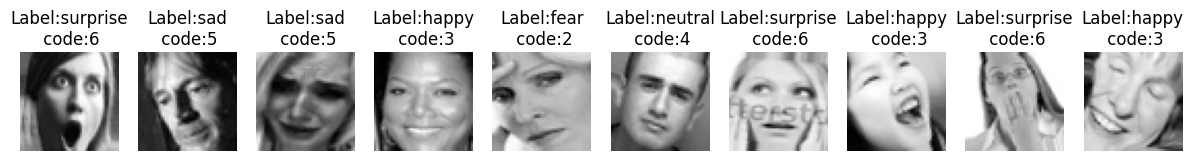

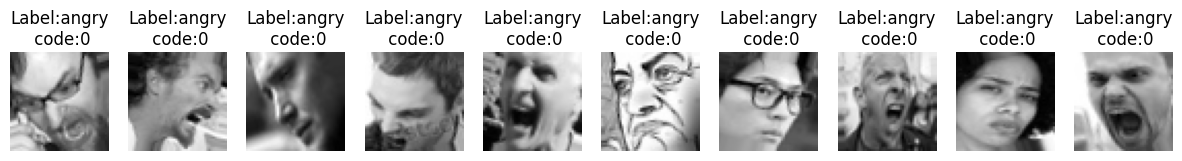

In [11]:
def plot_sample_data(generator,number_samples=10):
  images,labels= next(generator)

  class_indices= generator.class_indices
  #print("Class Indices:",class_indices)
  class_names= list(class_indices.keys())
  #print("Class Names:",class_names)

  plt.figure(figsize=(15,15))

  for i in range(number_samples):
    plt.subplot(1,number_samples,i+1)
    plt.imshow(images[i].reshape(image_size[0],image_size[1]),cmap='grey') # first convert then give color
    label_index= np.argmax(labels[i]) # argmax func returns indices of the max element of the array
    #print(label_index)
    label_name= class_names[label_index]
    plt.title(f'Label:{label_name}\n code:{label_index}')
    plt.axis('off')
  plt.show()

plot_sample_data(train_generator)
plot_sample_data(test_generator)



In [13]:
from keras.optimizers import Adam
# #Define Model
# base_model= VGG19(weights='imagenet', include_top= False, input_shape= (48,48,3))# in one channel since in gral scale only
# #Adding custom layers on top
# input_tensor= Input(shape= (48,48,1))
# layers=Conv2D(3,(1,1),padding='same')(input_tensor)
# layers= Model(inputs= input_tensor,outputs=layers)(input_tensor)
# base_model_output= base_model(layers)
# layers= base_model_output
# layers= GlobalAveragePooling2D()(layers)
# layers= Dense(512,activation='relu')(layers) # 256 no of neurons, relu for non linear
# layers= BatchNormalization()(layers)
# layers= Dropout(0.5)(layers)
# layers= Dense(256,activation='relu')(layers) # 256 no of neurons, relu for non linear
# layers= BatchNormalization()(layers)
# layers= Dropout(0.5)(layers)
# predictions = Dense(7,activation='softmax')(layers) #7 neurons since 7 class and softmax when multiclass classification

# model_vgg19= Model(inputs=input_tensor,outputs=predictions)
# for layer in base_model.layers[:-4]:
#   layer.trainable=False

# model_vgg19.compile(optimizer= Adam(learning_rate= 0.0001),loss= 'categorical_crossentropy', metrics= ['accuracy'])
# model_vgg19.summary()


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
input_tensor=Input(shape=(48,48,1))
x=Conv2D(3,(1,1),padding='same')(input_tensor)
x=Model(inputs=input_tensor,outputs=x)(input_tensor)
base_model_output=base_model(x)

x = base_model_output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x=Dense(256,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)
model_vgg19 = Model(inputs=input_tensor, outputs=predictions)
for layer in base_model.layers[:-4]:
    layer.trainable=False
optimizer=Adam(learning_rate=0.001)
model_vgg19.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_vgg19.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 48, 48, 3)           │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 1, 1, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,421,197 (77.90 MB)

 Trainable params: 7,475,725 (28.52 MB)

 Non-trainable params: 12,945,472 (49.38 MB)

In [14]:
history_vgg19= model_vgg19.fit(
    train_generator,
   # steps_per_epoch= train_generator.samples // batch_size,
    validation_data=  test_generator,
    #validation_steps = test_generator.samples // batch_size,
    epochs = 50
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 95ms/step - accuracy: 0.1741 - loss: 2.5325 - val_accuracy: 0.2742 - val_loss: 1.7830
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.2574 - loss: 1.8275 - val_accuracy: 0.3272 - val_loss: 1.6861
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 74ms/step - accuracy: 0.3108 - loss: 1.7143 - val_accuracy: 0.3299 - val_loss: 1.6636
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 72ms/step - accuracy: 0.3260 - loss: 1.6631 - val_accuracy: 0.3682 - val_loss: 1.5870
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.3586 - loss: 1.6087 - val_accuracy: 0.3750 - val_loss: 1.5787
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.3740 - loss: 1.5747 - val_accuracy: 0.3640 - val_loss: 1.6249
Epoch 7/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 73ms/step - accuracy: 0.3946 - loss: 1.5385 - val_accuracy: 0.3553 - val_loss: 1.6310
Epoch 8/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.3978 - loss: 1.5427 - val_accurac

In [15]:
model_vgg19.save('/content/my_model_vgg19.h5')

In [16]:
test_loss, test_accuracy = model_vgg19.evaluate(test_generator)
print(f'Test Accuracy:{test_accuracy*100:.2f}%')
print(f'Test Loss:{test_loss*100:.2f}%')

113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4949 - loss: 1.5989
Test Accuracy:54.32%
Test Loss:142.71%


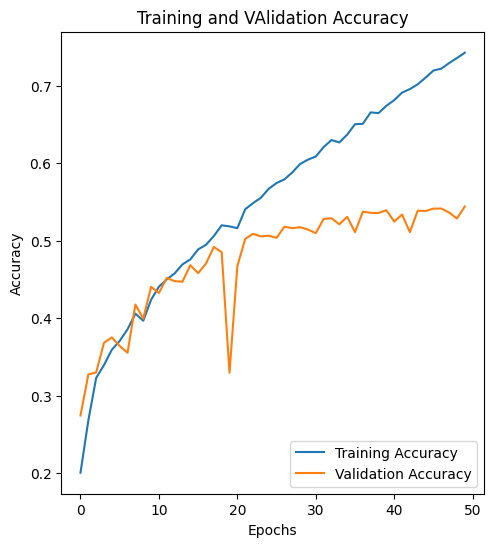

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg19.history['accuracy'],label= 'Training Accuracy')
plt.plot(history_vgg19.history['val_accuracy'],label= 'Validation Accuracy')
plt.title('Training and VAlidation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

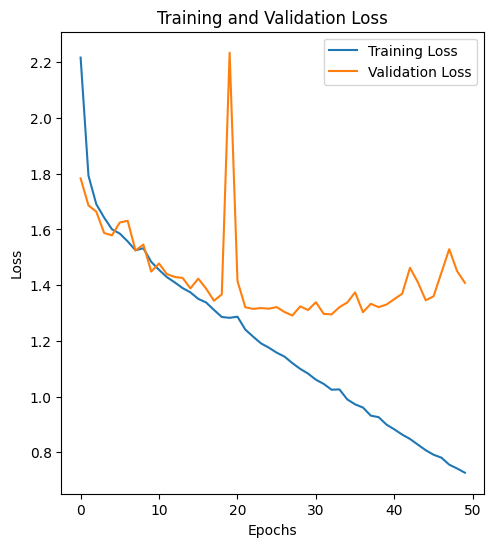

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_vgg19.history['loss'],label= 'Training Loss')
plt.plot(history_vgg19.history['val_loss'],label= 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred= model_vgg19.predict(test_generator)
y_pred= np.argmax(Y_pred,axis=1)
print('Confusion matrix')
print(confusion_matrix(test_generator.classes,y_pred))

print('Classification Report')
target_column= list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes,y_pred,target_names=target_column))



113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step
Confusion matrix
[[ 408    7   95  134  177  106   31]
 [  23   41    7   15   13   10    2]
 [ 120    1  348  101  174  182   98]
 [  68    4   36 1315  204   97   50]
 [  65    0   71  184  740  141   32]
 [ 118    5  157  183  319  434   31]
 [  16    2   66   67   79   17  584]]
Classification Report
              precision    recall  f1-score   support

       angry       0.50      0.43      0.46       958
     disgust       0.68      0.37      0.48       111
        fear       0.45      0.34      0.39      1024
       happy       0.66      0.74      0.70      1774
     neutral       0.43      0.60      0.50      1233
         sad       0.44      0.35      0.39      1247
    surprise       0.71      0.70      0.70       831

    accuracy                           0.54      7178
   macro avg       0.55      0.50      0.52      7178
weighted avg       0.54      0.54      0.53      7178

